<a href="https://colab.research.google.com/github/gouthami2309/Medical-Imaging-and-AI-Detecting-COVID-19-in-Radiographs/blob/main/Medical_Imaging_and_AI_Detecting_COVID_19_in_Radiographs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dataset includes medical imaging data (e.g., X-rays, CT scans, or other types of medical images) used to detect or analyze COVID-19 infections. Such datasets are often used in the medical and machine learning communities to develop and train diagnostic models, which can help in identifying COVID-19 from imaging data.

In [ ]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'covid19-image-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F627146%2F1117472%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240825%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240825T193334Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D1b1049c6492a4f96f86e4ef58a08a9cf496a317506f8116809b497e84729c63332e31f6548c27311c045e721c93c088933536638f175f439a59e2d094c03221422b29ec6c05f556f83f49abd4ff1fd1dde10d7c82f11323e7e33430e046982c7a9b352863dcd812c2cc4db4078d58d5fef96ba57c29cfc08b57535212ba1df49bf22b63b6850ca2ea3e2250eb7730287483570af3445fa98a2e20c6108800d3c1773fd2b8323097ed021fe3e47359ac592841cd4faa9a9fd9db6bab3a82d8845f4b537f01f763b7cc7276aa43a7cf8e3c328600070520974173c00c29bd9b7c732b4fb71b8c767d16cd7a693934a5a8a37636a55a560be63a7ab1ce099df3520'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 165557612 bytes downloaded
Downloaded and uncompressed: covid19-image-dataset
Data source import complete.


In [ ]:
import pandas as pd
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch
import random

from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
from sklearn.model_selection import train_test_split
import numpy as np

from sklearn.metrics import classification_report

In [ ]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Random seed set as {seed}")

In [ ]:
set_seed()

Random seed set as 42


# > **Hyperparameters**

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32
LR = 3e-4
NUM_EPOCH = 30
STEP_SIZE = 10
GAMMA = 0.5

In [ ]:
transform = tt.Compose([
    tt.ToTensor(),
    tt.Resize((IMG_SIZE, IMG_SIZE), antialias=True),
    tt.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225])])

In [ ]:
test_path = '/kaggle/input/covid19-image-dataset/Covid19-dataset/test'
train_path = '/kaggle/input/covid19-image-dataset/Covid19-dataset/train'
data_test = ImageFolder(test_path, transform=transform)
data_train = ImageFolder(train_path, transform=transform)

In [ ]:
len(data_test), len(data_train)

(66, 251)

In [ ]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
device

'cuda'

In [ ]:
train_loader = DataLoader(data_train,batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_loader = DataLoader(data_test, batch_size=BATCH_SIZE, drop_last=True)

In [ ]:
def model_eval(model, loader, loss_fn):
    model.eval()
    total_loss = 0.0
    total_acc = 0.0
    num_batches = len(loader)

    with torch.no_grad():
        for img, label in loader:
            out = model(img)
            loss = loss_fn(out, label)

            acc_ =(((out==label.argmax(1)).int().sum())/len(out)).item()
            total_loss += loss.item()
            total_acc += acc_

    avg_loss = total_loss / num_batches
    avg_acc = total_acc / num_batches

    model.train()
    return avg_acc, avg_loss

# > **AlexNet like model**

In [ ]:
class CNN(nn.Module):
    def __init__(self,inp_ch, out_ch):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=inp_ch, out_channels=96, kernel_size=(11,11), stride=4),
            nn.ReLU(),
            nn.BatchNorm2d(96))

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=(5,5), padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(256))

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=(3,3), padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(384),

            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=(3,3), padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            )

        self.detect_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=256*2*2, out_features=out_ch),
            nn.Softmax(dim=1)
        )


        self.Maxpool = nn.MaxPool2d(kernel_size=(3,3),stride=2)

    def forward(self,img):
        img = self.Maxpool(img)

        img = self.conv1(img)
        img = self.Maxpool(img)

        img = self.conv2(img)
        img = self.Maxpool(img)

        img = self.conv3(img)
        img = self.Maxpool(img)

        pred = self.detect_layer(img)

        return pred


In [ ]:
def train_model(model, optimizer, Loss_fn, scheduler, NUM_EPOCH=NUM_EPOCH, device=device):
    train_loss_list = []
    test_loss_list = []
    train_acc_list = []
    test_acc_list = []

    for epoch in range(NUM_EPOCH):
        model.train()
        loss_epoch = 0
        acc_train = 0

        for img, label in tqdm(train_loader):
            img = img.to(device)
            label = label.to(device)

            optimizer.zero_grad()

            out = model(img)
            loss = Loss_fn(out, label)
            loss_epoch += loss.item()

            loss.backward()
            optimizer.step()

            preds = out.argmax(dim=1)
            acc_train += (preds == label).sum().item()

        scheduler.step()
        avg_train_loss = loss_epoch / len(train_loader)
        train_loss_list.append(avg_train_loss)
        train_acc = acc_train / len(train_loader.dataset)
        train_acc_list.append(train_acc)

        #eval
        model.eval()
        loss_test_epoch = 0
        acc_test = 0

        with torch.no_grad():
            for img, label in test_loader:

                img = img.to(device)
                label = label.to(device)
                out = model(img)
                loss = Loss_fn(out, label)
                loss_test_epoch += loss.item()

                preds = out.argmax(dim=1)
                acc_test += (preds == label).sum().item()

        avg_test_loss = loss_test_epoch / len(test_loader)
        test_loss_list.append(avg_test_loss)
        test_acc = acc_test / len(test_loader.dataset)
        test_acc_list.append(test_acc)

        print(f"Epoch {epoch + 1}/{NUM_EPOCH}: "
              f"Train Loss = {avg_train_loss:.4f}, "
              f"Train Acc = {train_acc:.4f}, "
              f"Test Loss = {avg_test_loss:.4f}, "
              f"Test Acc = {test_acc:.4f}")

    return train_loss_list, test_loss_list, train_acc_list, test_acc_list

In [ ]:
def show_img(model, device=device):
    ig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 8))
    index = 0

    model.cpu()
    model.eval()
    with torch.no_grad():
        for i in range(3):
            for j in range(3):
                index = np.random.randint(len(data_test))
                img = data_test[index][0]
                label = data_test[index][1]
                pred = model(img.unsqueeze(0)).argmax().item()
                axes[i][j].imshow(img.permute(1, 2, 0).numpy())
                axes[i][j].set_title(f"Pred: {pred}\nLabel: {label}", fontsize=12)
                axes[i][j].axis('off')
    model.to(device)
    plt.tight_layout()
    plt.show()

This Model class encapsulates a PyTorch model along with associated training and evaluation functionalities. It:

Manages training using an optimizer and learning rate scheduler.
Computes evaluation metrics.
Visualizes training progress with loss and accuracy plots.
Allows for flexible usage on CPU or GPU devices.
This is a typical design for deep learning projects where maintaining structured and modular code is essential for managing complex training and evaluation workflows.

In [ ]:
class Model:
    def __init__(self, model, device=device):
        self.model = model.to(device)
        self.optimizer = Adam(self.model.parameters(), lr = LR )
        self.Loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1).to(device)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=STEP_SIZE, gamma=GAMMA)

    def __call__(self, img):
        if len(img.size()) == 3:
            return self.model(img.unsqueeze(0)).squeeze(0)
        return self.model(img)

    def metrics(self, loader):

        pred_list = []
        label_list = []

        with torch.no_grad():
            self.model.eval()
            for img, label in loader:

                img = img.to(device)
                label = label.to(device)

                out = self.model(img)
                pred_list.extend( out.argmax(1).tolist() )
                label_list.extend( label.tolist())

            self.model.train()
        print(classification_report(pred_list, label_list, zero_division=0))

    def train(self):
        train_loss_list, test_loss_list, train_acc_list, test_acc_list = train_model(model=self.model,
                                                                         optimizer=self.optimizer,
                                                                         Loss_fn=self.Loss_fn,
                                                                         scheduler=self.scheduler)

        plt.subplot(1, 2, 1)
        plt.plot(range(1, NUM_EPOCH + 1), train_loss_list, marker='o', label='Train Loss')
        plt.plot(range(1, NUM_EPOCH + 1), test_loss_list, marker='o', label='Test Loss')
        plt.title('Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid()

        plt.subplot(1, 2, 2)
        plt.plot(range(1, NUM_EPOCH + 1), train_acc_list, marker='o', label='Train Accuracy', color='blue')
        plt.plot(range(1, NUM_EPOCH + 1), test_acc_list, marker='o', label='Test Accuracy', color='orange')
        plt.title('Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid()

        plt.tight_layout()
        plt.show()

    def eval(self):
        self.model.eval()

    def cpu(self):
        self.model.cpu()

    def to(self, device):
        self.model.to(device)




These lines of code define a workflow for training and evaluating a CNN model:

An instance of the Model class is created with a CNN architecture.
The model is trained using the train() method, which handles the training loop, tracks performance metrics, and plots them.
The trained model is evaluated on a test dataset using the metrics() method, which prints detailed performance metrics.

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 1/30: Train Loss = 0.8295, Train Acc = 0.6813, Test Loss = 0.9509, Test Acc = 0.5909


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 2/30: Train Loss = 0.7266, Train Acc = 0.7849, Test Loss = 0.8735, Test Acc = 0.6364


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 3/30: Train Loss = 0.6968, Train Acc = 0.8048, Test Loss = 0.7560, Test Acc = 0.8030


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 4/30: Train Loss = 0.6567, Train Acc = 0.8526, Test Loss = 0.7011, Test Acc = 0.8636


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 5/30: Train Loss = 0.6440, Train Acc = 0.8645, Test Loss = 0.6749, Test Acc = 0.9091


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 6/30: Train Loss = 0.6315, Train Acc = 0.8805, Test Loss = 0.6727, Test Acc = 0.9091


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 7/30: Train Loss = 0.6293, Train Acc = 0.8845, Test Loss = 0.6716, Test Acc = 0.8939


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 8/30: Train Loss = 0.6268, Train Acc = 0.8884, Test Loss = 0.6512, Test Acc = 0.9242


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 9/30: Train Loss = 0.6383, Train Acc = 0.8765, Test Loss = 0.7040, Test Acc = 0.8788


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 10/30: Train Loss = 0.6255, Train Acc = 0.8884, Test Loss = 0.6381, Test Acc = 0.9545


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 11/30: Train Loss = 0.6231, Train Acc = 0.8884, Test Loss = 0.6448, Test Acc = 0.9545


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 12/30: Train Loss = 0.6196, Train Acc = 0.8924, Test Loss = 0.6488, Test Acc = 0.9394


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 13/30: Train Loss = 0.6185, Train Acc = 0.8924, Test Loss = 0.6463, Test Acc = 0.9394


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 14/30: Train Loss = 0.6183, Train Acc = 0.8924, Test Loss = 0.6480, Test Acc = 0.9394


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 15/30: Train Loss = 0.6182, Train Acc = 0.8924, Test Loss = 0.6504, Test Acc = 0.9394


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 16/30: Train Loss = 0.6184, Train Acc = 0.8924, Test Loss = 0.6483, Test Acc = 0.9394


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 17/30: Train Loss = 0.6183, Train Acc = 0.8924, Test Loss = 0.6463, Test Acc = 0.9394


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 18/30: Train Loss = 0.6183, Train Acc = 0.8924, Test Loss = 0.6423, Test Acc = 0.9394


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 19/30: Train Loss = 0.6182, Train Acc = 0.8924, Test Loss = 0.6432, Test Acc = 0.9394


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 20/30: Train Loss = 0.6189, Train Acc = 0.8924, Test Loss = 0.6444, Test Acc = 0.9394


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 21/30: Train Loss = 0.6182, Train Acc = 0.8924, Test Loss = 0.6439, Test Acc = 0.9394


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 22/30: Train Loss = 0.6182, Train Acc = 0.8924, Test Loss = 0.6401, Test Acc = 0.9545


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 23/30: Train Loss = 0.6186, Train Acc = 0.8924, Test Loss = 0.6357, Test Acc = 0.9545


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 24/30: Train Loss = 0.6183, Train Acc = 0.8924, Test Loss = 0.6355, Test Acc = 0.9545


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 25/30: Train Loss = 0.6183, Train Acc = 0.8924, Test Loss = 0.6357, Test Acc = 0.9545


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 26/30: Train Loss = 0.6182, Train Acc = 0.8924, Test Loss = 0.6365, Test Acc = 0.9545


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 27/30: Train Loss = 0.6182, Train Acc = 0.8924, Test Loss = 0.6383, Test Acc = 0.9545


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 28/30: Train Loss = 0.6182, Train Acc = 0.8924, Test Loss = 0.6396, Test Acc = 0.9545


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 29/30: Train Loss = 0.6182, Train Acc = 0.8924, Test Loss = 0.6389, Test Acc = 0.9545


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 30/30: Train Loss = 0.6181, Train Acc = 0.8924, Test Loss = 0.6392, Test Acc = 0.9545


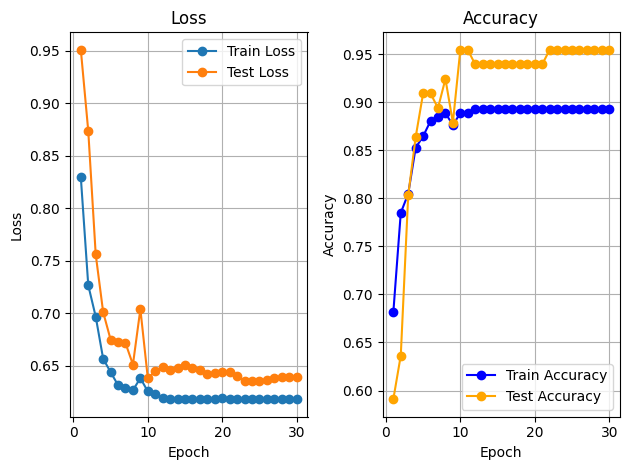

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        26
           1       1.00      0.95      0.98        21
           2       0.94      1.00      0.97        17

    accuracy                           0.98        64
   macro avg       0.98      0.98      0.98        64
weighted avg       0.99      0.98      0.98        64



In [ ]:
Alex_Net = Model(CNN(3,3))
Alex_Net.train()
Alex_Net.metrics(test_loader)

# > ***Time to ResNet***

# all layers are unfreeze

In [ ]:
resnet18_v1 = models.resnet18(pretrained=True)
resnet18_v1.fc = nn.Linear(resnet18_v1.fc.in_features, 3)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 166MB/s]


Initialization (ResNet18_v1 = Model(resnet18_v1)): A ResNet-18 model is wrapped in a Model class, which handles training and evaluation.
Training (ResNet18_v1.train()): The model is trained on the training dataset, with loss and accuracy metrics tracked and plotted.
Evaluation (ResNet18_v1.metrics(test_loader)): The model's performance is evaluated on a separate test dataset, providing detailed classification metrics.

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 1/30: Train Loss = 0.5565, Train Acc = 0.7610, Test Loss = 0.5568, Test Acc = 0.8939


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 2/30: Train Loss = 0.3869, Train Acc = 0.8566, Test Loss = 0.4440, Test Acc = 0.9091


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 3/30: Train Loss = 0.3409, Train Acc = 0.8884, Test Loss = 0.4896, Test Acc = 0.8636


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 4/30: Train Loss = 0.3363, Train Acc = 0.8884, Test Loss = 0.3774, Test Acc = 0.9545


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 5/30: Train Loss = 0.3220, Train Acc = 0.8924, Test Loss = 0.3779, Test Acc = 0.9394


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 6/30: Train Loss = 0.3155, Train Acc = 0.8924, Test Loss = 0.3537, Test Acc = 0.9545


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 7/30: Train Loss = 0.3078, Train Acc = 0.8924, Test Loss = 0.3434, Test Acc = 0.9697


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 8/30: Train Loss = 0.3037, Train Acc = 0.8924, Test Loss = 0.3387, Test Acc = 0.9697


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 9/30: Train Loss = 0.3065, Train Acc = 0.8924, Test Loss = 0.3482, Test Acc = 0.9545


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 10/30: Train Loss = 0.3000, Train Acc = 0.8924, Test Loss = 0.3503, Test Acc = 0.9697


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 11/30: Train Loss = 0.3052, Train Acc = 0.8924, Test Loss = 0.3507, Test Acc = 0.9545


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 12/30: Train Loss = 0.2996, Train Acc = 0.8924, Test Loss = 0.3639, Test Acc = 0.9394


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 13/30: Train Loss = 0.2973, Train Acc = 0.8924, Test Loss = 0.3485, Test Acc = 0.9697


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 14/30: Train Loss = 0.2946, Train Acc = 0.8924, Test Loss = 0.3501, Test Acc = 0.9545


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 15/30: Train Loss = 0.2953, Train Acc = 0.8924, Test Loss = 0.3515, Test Acc = 0.9545


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 16/30: Train Loss = 0.2977, Train Acc = 0.8924, Test Loss = 0.3489, Test Acc = 0.9545


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 17/30: Train Loss = 0.2947, Train Acc = 0.8924, Test Loss = 0.3530, Test Acc = 0.9545


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 18/30: Train Loss = 0.3003, Train Acc = 0.8924, Test Loss = 0.3479, Test Acc = 0.9545


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 19/30: Train Loss = 0.2967, Train Acc = 0.8924, Test Loss = 0.3511, Test Acc = 0.9545


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 20/30: Train Loss = 0.2951, Train Acc = 0.8924, Test Loss = 0.3502, Test Acc = 0.9545


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 21/30: Train Loss = 0.3016, Train Acc = 0.8924, Test Loss = 0.3516, Test Acc = 0.9545


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 22/30: Train Loss = 0.2985, Train Acc = 0.8924, Test Loss = 0.3529, Test Acc = 0.9545


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 23/30: Train Loss = 0.2963, Train Acc = 0.8924, Test Loss = 0.3542, Test Acc = 0.9545


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 24/30: Train Loss = 0.2977, Train Acc = 0.8924, Test Loss = 0.3550, Test Acc = 0.9545


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 25/30: Train Loss = 0.2980, Train Acc = 0.8924, Test Loss = 0.3523, Test Acc = 0.9545


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 26/30: Train Loss = 0.2946, Train Acc = 0.8924, Test Loss = 0.3574, Test Acc = 0.9545


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 27/30: Train Loss = 0.3009, Train Acc = 0.8924, Test Loss = 0.3495, Test Acc = 0.9545


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 28/30: Train Loss = 0.2945, Train Acc = 0.8924, Test Loss = 0.3524, Test Acc = 0.9545


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 29/30: Train Loss = 0.2941, Train Acc = 0.8924, Test Loss = 0.3594, Test Acc = 0.9545


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 30/30: Train Loss = 0.2978, Train Acc = 0.8924, Test Loss = 0.3531, Test Acc = 0.9545


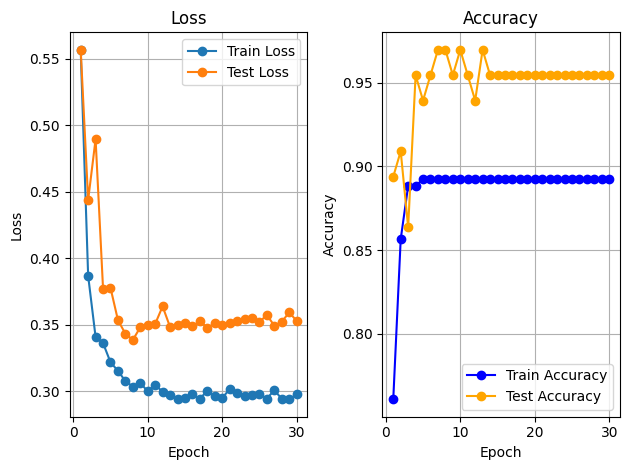

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        26
           1       0.95      1.00      0.97        19
           2       1.00      0.95      0.97        19

    accuracy                           0.98        64
   macro avg       0.98      0.98      0.98        64
weighted avg       0.99      0.98      0.98        64



In [ ]:
ResNet18_v1 = Model(resnet18_v1)
ResNet18_v1.train()
ResNet18_v1.metrics(test_loader)

The model shows excellent performance across all classes, with near-perfect precision, recall, and F1-scores, especially for classes 0 and 1.
The slight drop in recall for class 2 indicates a few instances were missed, but overall, the performance is still very high.
An accuracy of 98% suggests the model is highly effective at correctly classifying the test instances.

# **unfreeze 2 layers**

In [ ]:
def freeze_layers(model, num_layers: int):
    for param in model.parameters():
        param.requires_grad = False

    params = list(model.parameters())

    for param in params[-num_layers:]:
        param.requires_grad = True


In [ ]:
resnet18_v2 = models.resnet18(pretrained=True)
resnet18_v2.fc = nn.Linear(resnet18_v2.fc.in_features, 3)
freeze_layers(resnet18_v2, 3)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 1/30: Train Loss = 1.2386, Train Acc = 0.2231, Test Loss = 1.2143, Test Acc = 0.3182


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 2/30: Train Loss = 1.1461, Train Acc = 0.3187, Test Loss = 1.1321, Test Acc = 0.3485


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 3/30: Train Loss = 1.0436, Train Acc = 0.4064, Test Loss = 1.1060, Test Acc = 0.5000


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 4/30: Train Loss = 0.9820, Train Acc = 0.4821, Test Loss = 1.1023, Test Acc = 0.5152


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 5/30: Train Loss = 0.9161, Train Acc = 0.5657, Test Loss = 1.0836, Test Acc = 0.5909


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 6/30: Train Loss = 0.8554, Train Acc = 0.6255, Test Loss = 1.0374, Test Acc = 0.5152


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 7/30: Train Loss = 0.8104, Train Acc = 0.6653, Test Loss = 0.9994, Test Acc = 0.5606


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 8/30: Train Loss = 0.7856, Train Acc = 0.6853, Test Loss = 0.9308, Test Acc = 0.5606


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 9/30: Train Loss = 0.7198, Train Acc = 0.7251, Test Loss = 0.8946, Test Acc = 0.5909


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 10/30: Train Loss = 0.7072, Train Acc = 0.7490, Test Loss = 0.8492, Test Acc = 0.6515


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 11/30: Train Loss = 0.6895, Train Acc = 0.7371, Test Loss = 0.8254, Test Acc = 0.7121


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 12/30: Train Loss = 0.6556, Train Acc = 0.7769, Test Loss = 0.8111, Test Acc = 0.7121


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 13/30: Train Loss = 0.6607, Train Acc = 0.7570, Test Loss = 0.7978, Test Acc = 0.7121


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 14/30: Train Loss = 0.6368, Train Acc = 0.7928, Test Loss = 0.7941, Test Acc = 0.7121


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 15/30: Train Loss = 0.6351, Train Acc = 0.7769, Test Loss = 0.7837, Test Acc = 0.6818


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 16/30: Train Loss = 0.6042, Train Acc = 0.8127, Test Loss = 0.7677, Test Acc = 0.7273


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 17/30: Train Loss = 0.6043, Train Acc = 0.7968, Test Loss = 0.7563, Test Acc = 0.7424


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 18/30: Train Loss = 0.5997, Train Acc = 0.7968, Test Loss = 0.7509, Test Acc = 0.7424


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 19/30: Train Loss = 0.5955, Train Acc = 0.7689, Test Loss = 0.7474, Test Acc = 0.7424


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 20/30: Train Loss = 0.5843, Train Acc = 0.8167, Test Loss = 0.7372, Test Acc = 0.7576


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 21/30: Train Loss = 0.5692, Train Acc = 0.8127, Test Loss = 0.7321, Test Acc = 0.7576


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 22/30: Train Loss = 0.5625, Train Acc = 0.8207, Test Loss = 0.7258, Test Acc = 0.7879


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 23/30: Train Loss = 0.5629, Train Acc = 0.8127, Test Loss = 0.7245, Test Acc = 0.7879


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 24/30: Train Loss = 0.5615, Train Acc = 0.8088, Test Loss = 0.7210, Test Acc = 0.7879


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 25/30: Train Loss = 0.5662, Train Acc = 0.8088, Test Loss = 0.7182, Test Acc = 0.7879


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 26/30: Train Loss = 0.5622, Train Acc = 0.8127, Test Loss = 0.7144, Test Acc = 0.7576


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 27/30: Train Loss = 0.5574, Train Acc = 0.8048, Test Loss = 0.7078, Test Acc = 0.7879


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 28/30: Train Loss = 0.5411, Train Acc = 0.8287, Test Loss = 0.7061, Test Acc = 0.7879


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 29/30: Train Loss = 0.5524, Train Acc = 0.8327, Test Loss = 0.7015, Test Acc = 0.8030


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 30/30: Train Loss = 0.5801, Train Acc = 0.7849, Test Loss = 0.7022, Test Acc = 0.8030


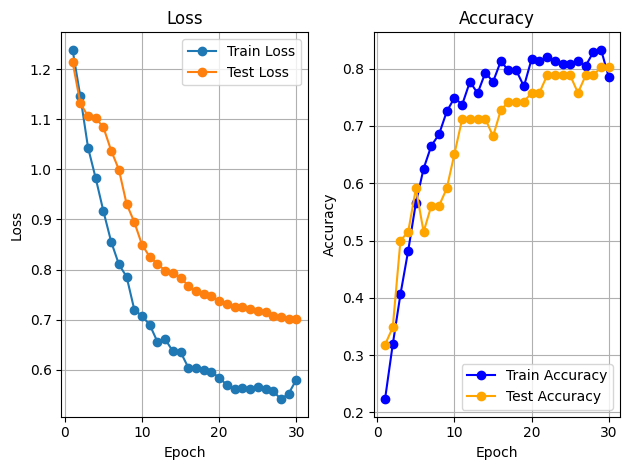

              precision    recall  f1-score   support

           0       1.00      0.81      0.90        32
           1       0.75      1.00      0.86        15
           2       0.67      0.71      0.69        17

    accuracy                           0.83        64
   macro avg       0.81      0.84      0.81        64
weighted avg       0.85      0.83      0.83        64



In [ ]:
ResNet18_v2 = Model(resnet18_v2)
ResNet18_v2.train()
ResNet18_v2.metrics(test_loader)

In [ ]:
vit = models.vit_b_16(weights='IMAGENET1K_V1')
vit.heads = nn.Linear(768, 3)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:06<00:00, 53.2MB/s]


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 1/30: Train Loss = 1.5630, Train Acc = 0.4382, Test Loss = 1.0710, Test Acc = 0.5303


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 2/30: Train Loss = 1.0540, Train Acc = 0.4263, Test Loss = 0.9840, Test Acc = 0.3939


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 3/30: Train Loss = 0.9151, Train Acc = 0.4661, Test Loss = 0.8552, Test Acc = 0.5606


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 4/30: Train Loss = 0.7706, Train Acc = 0.5578, Test Loss = 0.6651, Test Acc = 0.7879


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 5/30: Train Loss = 0.7063, Train Acc = 0.6295, Test Loss = 0.7721, Test Acc = 0.5909


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 6/30: Train Loss = 0.6821, Train Acc = 0.6135, Test Loss = 0.9933, Test Acc = 0.5606


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 7/30: Train Loss = 0.6740, Train Acc = 0.6733, Test Loss = 0.8468, Test Acc = 0.6212


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 8/30: Train Loss = 0.6323, Train Acc = 0.7131, Test Loss = 0.6735, Test Acc = 0.6970


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 9/30: Train Loss = 0.4784, Train Acc = 0.8127, Test Loss = 0.6421, Test Acc = 0.7727


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 10/30: Train Loss = 0.4557, Train Acc = 0.8207, Test Loss = 0.6476, Test Acc = 0.7879


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 11/30: Train Loss = 0.3956, Train Acc = 0.8526, Test Loss = 0.6872, Test Acc = 0.7727


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 12/30: Train Loss = 0.3490, Train Acc = 0.8805, Test Loss = 0.7040, Test Acc = 0.7424


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 13/30: Train Loss = 0.3308, Train Acc = 0.8805, Test Loss = 0.7556, Test Acc = 0.7121


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 14/30: Train Loss = 0.3251, Train Acc = 0.8845, Test Loss = 0.6646, Test Acc = 0.7879


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 15/30: Train Loss = 0.3124, Train Acc = 0.8884, Test Loss = 0.6865, Test Acc = 0.7727


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 16/30: Train Loss = 0.3024, Train Acc = 0.8924, Test Loss = 0.7568, Test Acc = 0.7424


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 17/30: Train Loss = 0.3046, Train Acc = 0.8884, Test Loss = 0.7164, Test Acc = 0.7424


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 18/30: Train Loss = 0.3009, Train Acc = 0.8884, Test Loss = 0.7092, Test Acc = 0.7576


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 19/30: Train Loss = 0.2967, Train Acc = 0.8924, Test Loss = 0.7152, Test Acc = 0.7576


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 20/30: Train Loss = 0.2958, Train Acc = 0.8924, Test Loss = 0.7366, Test Acc = 0.7576


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 21/30: Train Loss = 0.2945, Train Acc = 0.8924, Test Loss = 0.7229, Test Acc = 0.7424


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 22/30: Train Loss = 0.2940, Train Acc = 0.8924, Test Loss = 0.7235, Test Acc = 0.7273


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 23/30: Train Loss = 0.2938, Train Acc = 0.8924, Test Loss = 0.7095, Test Acc = 0.7273


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 24/30: Train Loss = 0.2935, Train Acc = 0.8924, Test Loss = 0.7108, Test Acc = 0.7424


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 25/30: Train Loss = 0.2932, Train Acc = 0.8924, Test Loss = 0.7149, Test Acc = 0.7424


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 26/30: Train Loss = 0.2930, Train Acc = 0.8924, Test Loss = 0.7172, Test Acc = 0.7424


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 27/30: Train Loss = 0.2929, Train Acc = 0.8924, Test Loss = 0.7126, Test Acc = 0.7424


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 28/30: Train Loss = 0.2928, Train Acc = 0.8924, Test Loss = 0.7148, Test Acc = 0.7424


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 29/30: Train Loss = 0.2926, Train Acc = 0.8924, Test Loss = 0.7151, Test Acc = 0.7424


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 30/30: Train Loss = 0.2925, Train Acc = 0.8924, Test Loss = 0.7174, Test Acc = 0.7424


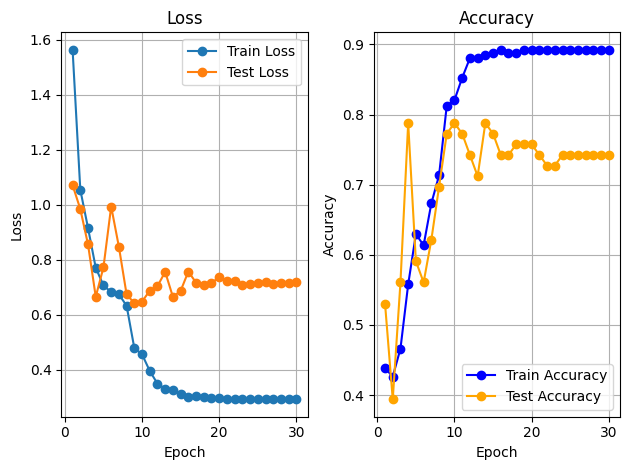

              precision    recall  f1-score   support

           0       0.92      0.96      0.94        25
           1       0.55      0.73      0.63        15
           2       0.78      0.58      0.67        24

    accuracy                           0.77        64
   macro avg       0.75      0.76      0.75        64
weighted avg       0.78      0.77      0.76        64



In [ ]:
VIT = Model(vit)
VIT.train()
VIT.metrics(test_loader)

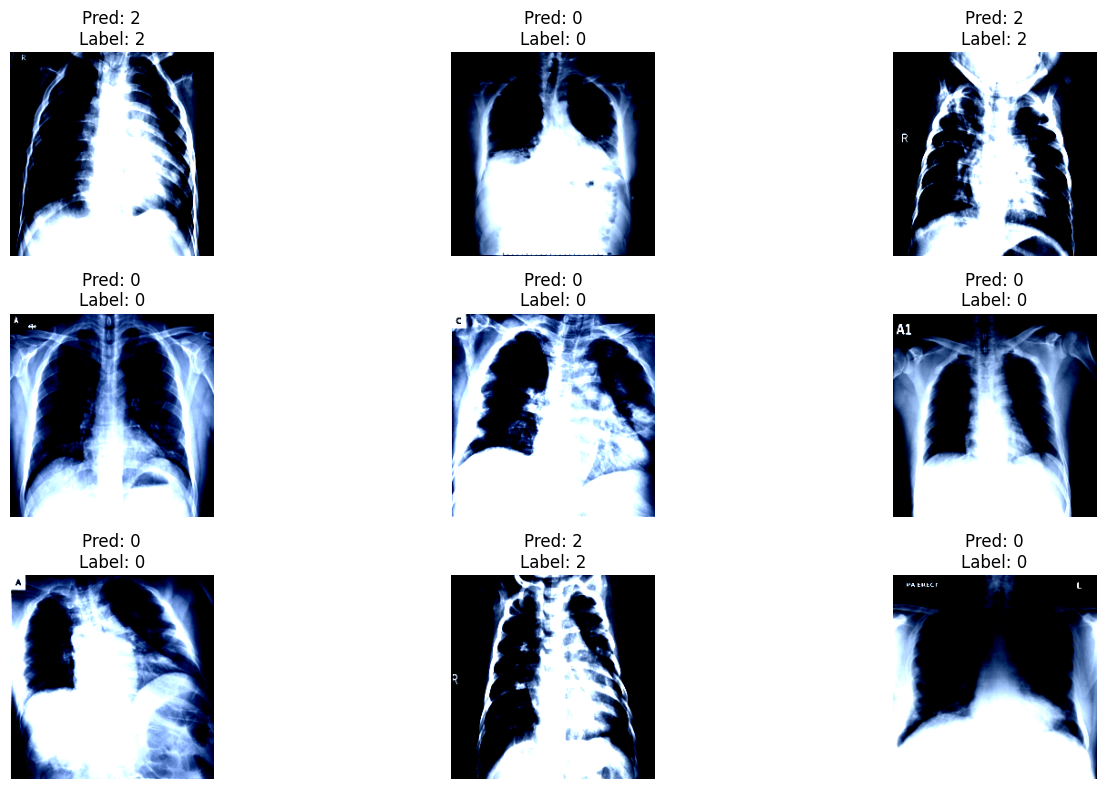

In [ ]:
show_img(VIT)

# **END**